In [18]:
import imblearn
from itertools import combinations, cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.ensemble
import sklearn.linear_model
from sklearn.metrics import RocCurveDisplay
import sklearn.neighbors
import sklearn.preprocessing
import statsmodels
import statistics
from numpy import absolute, mean, sqrt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import ConfusionMatrixDisplay, auc, roc_curve
from sklearn.model_selection import LeaveOneOut, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelBinarizer
from statsmodels.sandbox.stats.multicomp import multipletests
from xgboost import XGBClassifier

import sys

from apply_ml_model import apply_ml_model
from bp_preprocessing import handle_scale_and_nan, over_under

list_features = ['AK1C1','TAU', '1433G', 'SCUB1', 'FMOD', 'AMYP', 'CRIS3', 
                'MYDGF', 'RARR2', 'ATS8', 'PGK1', '1433Z', 'SV2A', 'TRH', 'GUAD', 
                'HV69D', 'CO7', 'SERC']
classes_of_interest=['Healthy', 'PD_MCI_LBD', 'PD', 'AD_MCI']

def pre_process_data(data_dev, data_test): 
    data_dev = handle_scale_and_nan(data_dev)
    data_test = handle_scale_and_nan(data_test)
    data_dev = data_dev.drop(columns='assay_ID')
    data_test = data_test.drop(columns='assay_ID')
    data_dev = over_under(data_dev) #split groups equally 
    return data_dev, data_test


def roc_curves_one_vs_rest(data_dev, data_test):
    data_dev, data_test = pre_process_data(data_dev, data_test)
    
    dev = data_dev[list_features]
    dev.insert(0, "group", data_dev['group'], True)
    
    X_test = data_test[list_features]
    y_test = data_test['group']

    X_train = dev.iloc[:,1:] 
    y_train = dev.iloc[:,0] # 0th column is our target


    classifier = sklearn.ensemble.RandomForestClassifier()
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red'])
    for class_id, color in zip(range(4), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {classes_of_interest[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves, using {len(list_features)} features")
    plt.legend()
    plt.savefig('roc_curves.png')
    plt.show()
 

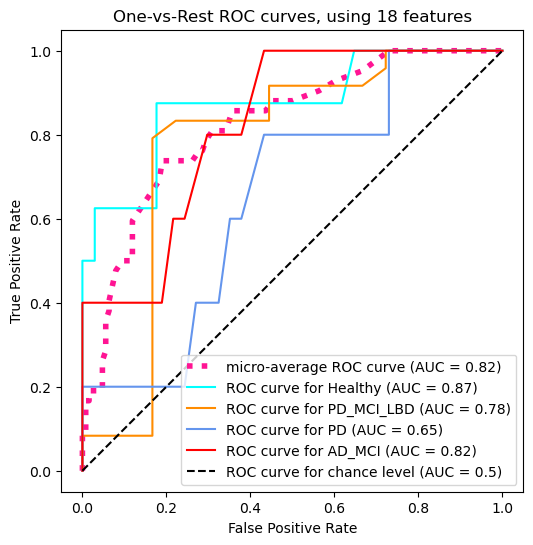

In [19]:
data_dev = pd.read_csv("/Users/mariamb/Documents/GitHub/BrainPower/brainpower/data/split_data/dev.csv")
data_test = pd.read_csv("/Users/mariamb/Documents/GitHub/BrainPower/brainpower/data/split_data/test.csv")
roc_curves_one_vs_rest(data_dev, data_test)

In the terminal: 
python generate_roc_curves.py /Users/mariamb/Documents/GitHub/BrainPower/brainpower/data/split_data/dev.csv /Users/mariamb/Documents/GitHub/BrainPower/brainpower/data/split_data/test.csv